# ETITAN_2007

- **Paper**: 3D Convective Storm Identification, Tracking, and Forecasting - An Enhanced TITAN Algorithm

- $\textbf{\textcolor{red}{Identification}}$:
    + **Segmentation**: 
        + Multiple thresholds
        + Apply *mathematical morphology*: erode to eliminate false merge, dilate to fill the stronger storm within the storm with lower dBz bounded
    
    + **Feature representation**:
        + *The same as `TITAN_1993`*

- $\textbf{\textcolor{blue}{Tracking}}$:
    + **Motion estimation**: Estimate the composite motion vector-field using TREC - Correlation. For each block in curr frame, search for local region with max corr:
        + *Search space*: local region with bounded velocity.
        + *Vector motion*: point to region with max corr.
    
    + **Matching**: implement a 2-stage tracking:
        + *1st*: forecast using correlation: if 2 storms are ovelapped much, they are from the same track. For unmatched storm, we process them  in step 2.
        + *2nd*: Hungarian matching is applied with the dynamic constraint on the displacement bounded. 

        + *Handling split & merge*: the same as `TITAN_1993`.

- $\textbf{\textcolor{yellow}{Nowcasting}}$: instead of using centroid displacement => use estimated vector motion from TREC.
    + Avg value is used as the estimated vector motion of each storm
    + For other paramters => the same.

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2

## Prepare dataset

In [79]:
from src.preprocessing import read_image, windy_preprocessing_pipeline
from tqdm.notebook import tqdm

data_name = "philippines_13.269_123.832"
SOURCE_PATH = f"data/image_old/{data_name}"

img_paths = [
    os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.png')
][:50]

img_shape = read_image(img_paths[0]).shape       # get shape of the image
print(f"Image shape: {img_shape}")
print(f"-" * 20)

dbz_maps = []

for path in tqdm(img_paths, desc="Processing images and detecting storms"):
    img = read_image(path)
    dbz_maps.append(windy_preprocessing_pipeline(img))

print(f"Number of frames: {len(dbz_maps)}")

Image shape: (505, 1220, 3)
--------------------


Processing images and detecting storms:   0%|          | 0/50 [00:00<?, ?it/s]

Number of frames: 50


In [80]:
# from src.preprocessing import read_numpy_grid, nexrad_numpy_preprocessing_pipeline
# from tqdm.notebook import tqdm

# data_name = "KDVN"

# SOURCE_PATH = f"data/numpy_grid/{data_name}"

# img_paths = [
#     os.path.join(SOURCE_PATH, img_name) for img_name in sorted(os.listdir(SOURCE_PATH)) if img_name.endswith('.npy')
# ]

# # img_shape = read_numpy_grid(img_paths[0]).shape       # get shape of the image
# print(f"-" * 20)

# dbz_maps = []

# for path in tqdm(img_paths, desc="Processing images and detecting storms"):
#     img = read_numpy_grid(path)
#     dbz_map = nexrad_numpy_preprocessing_pipeline(img)
#     dbz_maps.append(np.nan_to_num(dbz_map))

# dbz_map_sample = dbz_maps[0]
# img_shape = (dbz_map_sample.shape[0], dbz_map_sample.shape[1], 3)
# print(f"Image shape: {img_shape}")

# print(f"Number of frames: {len(dbz_maps)}")

## 1. Identification

In [81]:
from src.identification import MorphContourIdentifier, HypothesisIdentifier
from src.preprocessing import convert_contours_to_polygons, convert_polygons_to_contours
from src.cores.base import StormObject, StormsMap
from datetime import datetime
from shapely import Polygon
from skimage.measure import block_reduce

THRESHOLD = 35
DISTANCE_DBZ = 5
FILTER_AREA = 20        # storm with area under this threshold => cancel
FILTER_CENTER = 10

class CentroidStorm(StormObject):
    centroid: np.ndarray
    estimated_movement: tuple[float, float] = (None, None)

    def __init__(self, polygon: Polygon, centroid: tuple[float, float], id: str=""):
        super().__init__(contour=polygon, id=id)
        self.centroid = np.array(centroid)
    
    def retrieve_movement(self):
        """
        Retrieve movement of the current storm by averaging the estimated-motion map over the storm area.

        Returns:
        -------
        estimated_movement : tuple[float, float]
            Estimated movement (dy, dx) of the storm.
        """
        return self.estimated_movement

    def update_movement(self, **kargs):
        # retrieve parameters of estimatied-motion map.
        grid_y = kargs.get("grid_y", np.array([]))
        grid_x = kargs.get("grid_x", np.array([]))
        vy = kargs.get("vy", np.array([]))
        vx = kargs.get("vx", np.array([]))

        if len(grid_y) == 0:
            return np.array([0,0])

        block_size = int(grid_y[0] * 2)

        contours = convert_polygons_to_contours([self.contour])
        mask = np.zeros(img_shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, contours, color=1)

        crop_mask = mask[0:block_size * len(grid_y), 0:block_size * len(grid_x)]

        block_mask = block_reduce(crop_mask, block_size=(block_size,block_size), func=np.sum)
        total = np.sum(block_mask) + 1e-8
        dy = np.sum(vy * block_mask) / total
        dx = np.sum(vx * block_mask) / total

        self.estimated_movement = (dy, dx)

        return dy, dx

class DbzStormsMap(StormsMap):
    storms: list[CentroidStorm]
    dbz_map: np.ndarray

    def __init__(self, storms: list[CentroidStorm], time_frame: datetime, dbz_map: np.ndarray):
        """
        Beside 2 default attributes, also keep track of `dbz_map` for computin correlation.
        """
        super().__init__(storms, time_frame)
        self.dbz_map = dbz_map

    def _retrieve_block_movement(self, block: np.ndarray, search_region: np.ndarray) -> np.ndarray:
        block = block.astype(np.float32)
        search_region = search_region.astype(np.float32)
        result = cv2.matchTemplate(search_region, block, cv2.TM_CCOEFF_NORMED)
        return np.unravel_index(np.argmax(result), result.shape)

    
    def trec_estimate(self, prev_storms_map: "DbzStormsMap", **kargs) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
        Generate a correlation map which show the movement between the current to the previous storm map. 
        Returns the grid of block centers and their corresponding displacements.

        Args
        -------
            other: DbzStormsMap
                the next storm map to compare
            block_size: int, optional
                size of the blocks to use for correlation. Defaults to 16.
            stride: int, optional
                stride for moving the block window. Defaults to block_size.
            buffer: int, optional
                buffer size around the block for search region. Defaults to 50.

        Returns
        -------
        grid_y : np.ndarray
            Array of y-coordinates (in pixels) of block centers.
        grid_x : np.ndarray
            Array of x-coordinates (in pixels) of block centers.
        vy : np.ndarray
            Array of y-displacements for each block center.
        vx : np.ndarray
            Array of x-displacements for each block center.
        """
        block_size = kargs.get("block_size", 16)
        stride = kargs.get("stride", block_size)
        local_buffer = kargs.get("buffer", 50)      # search region = block + expanded by local_buffer


        dbz_map_1 = self.dbz_map
        dbz_map_2 = prev_storms_map.dbz_map
        H, W = dbz_map_2.shape

        ys = list(range(0, H-block_size+1, stride))     # ys: list[start_idx of H-axis]
        xs = list(range(0, W-block_size+1, stride))     # xs: list[start_idx of W-axis]

        vy = np.zeros(shape=(len(ys), len(xs)))         # vy: keep the y-value of movement at corresponding position
        vx = np.zeros_like(vy)                          # vx: keep the x-value of movement at corresponding position

        for i, y in enumerate(ys):
            for j, x in enumerate(xs):
                block = dbz_map_1[y:y+block_size, x:x+block_size]

                if np.std(block) < 1e-5:    # case std is too small => continue
                    continue

                # otherwise: get the search region
                y_search_low, y_search_high = max(0,y-local_buffer), min(H,y + block_size + local_buffer)   # ensure the seach region is not overflow.
                x_search_low, x_search_high = max(0,x-local_buffer), min(W,x + block_size + local_buffer)

                # find the best-matched position in the search region
                search_region = dbz_map_2[y_search_low:y_search_high, x_search_low:x_search_high]
                dy, dx = self._retrieve_block_movement(block, search_region)

                y_center, x_center = y_search_low + dy + block_size / 2, x_search_low + dx + block_size / 2
                y_block_center = y + block_size / 2
                x_block_center = x + block_size / 2

                # displacement from dbz_map_1 -> dbz_map_2 = center - original position
                vy[i][j] = y_center - y_block_center
                vx[i][j] = x_center - x_block_center
        
        # Get the center of the block
        grid_y = np.array(ys) + block_size // 2
        grid_x = np.array(xs) + block_size // 2

        # invert the direction: from previous -> current
        vy = -vy
        vx = -vx

        # auto assign estimated movement to each storm
        for storm in self.storms:
            storm.update_movement(grid_y=grid_y, grid_x=grid_x, vy=vy, vx=vx)

        return grid_y, grid_x, vy, vx

Processing images and detecting storms:   0%|          | 0/50 [00:00<?, ?it/s]

--------------------
Time: 2025-01-08 03:10:44 | Detected storms: 11
Time: 2025-01-08 03:16:44 | Detected storms: 14
Time: 2025-01-08 03:22:45 | Detected storms: 9
Time: 2025-01-08 03:28:45 | Detected storms: 11
Time: 2025-01-08 03:34:45 | Detected storms: 9
Time: 2025-01-08 03:40:45 | Detected storms: 13
Time: 2025-01-08 03:46:46 | Detected storms: 20
Time: 2025-01-08 03:52:46 | Detected storms: 14
Time: 2025-01-08 03:58:46 | Detected storms: 11
Time: 2025-01-08 04:04:46 | Detected storms: 13
Time: 2025-01-08 04:10:47 | Detected storms: 12
Time: 2025-01-08 04:16:47 | Detected storms: 14
Time: 2025-01-08 04:22:47 | Detected storms: 21
Time: 2025-01-08 04:28:47 | Detected storms: 16
Time: 2025-01-08 04:34:48 | Detected storms: 17
Time: 2025-01-08 04:40:48 | Detected storms: 11
Time: 2025-01-08 04:46:48 | Detected storms: 9
Time: 2025-01-08 04:52:48 | Detected storms: 15
Time: 2025-01-08 04:58:49 | Detected storms: 13
Time: 2025-01-08 05:04:49 | Detected storms: 12
Time: 2025-01-08 05:10

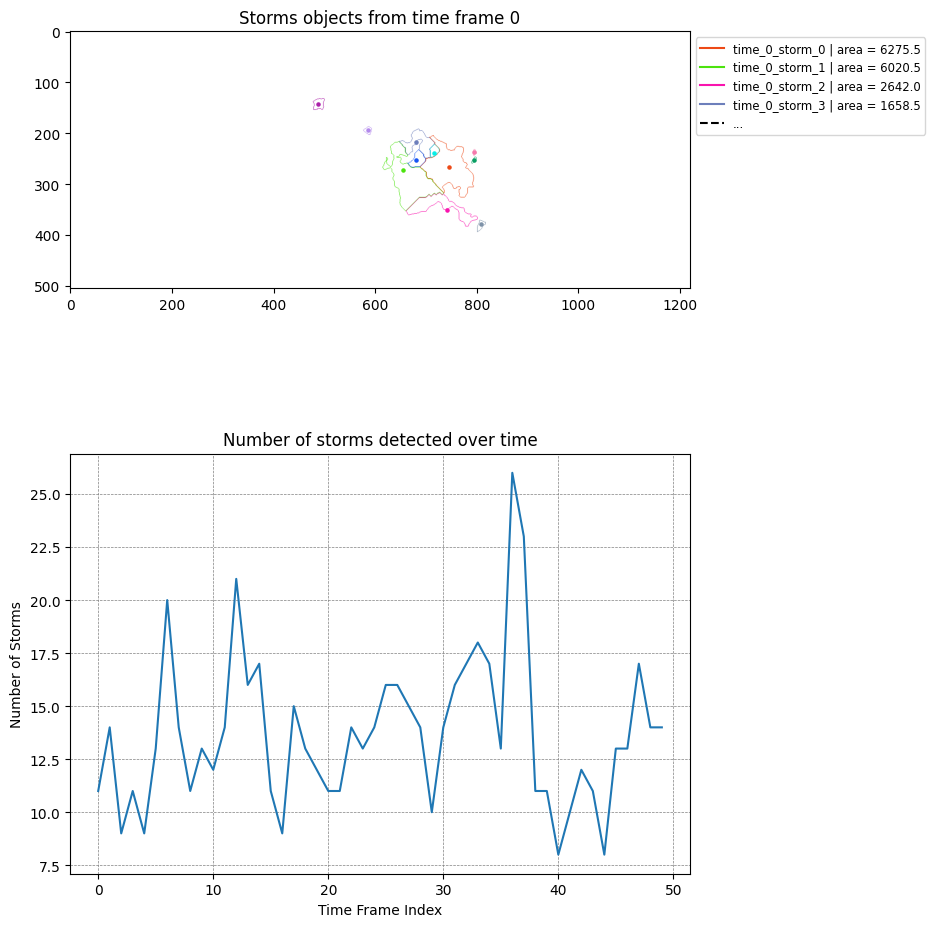

In [82]:
# identifier = MorphContourIdentifier()
identifier = HypothesisIdentifier(distance_dbz_threshold=DISTANCE_DBZ, filter_center=FILTER_CENTER)
storms_map_time_lst: list[DbzStormsMap] = []

for time_idx, (path, dbz_map) in tqdm(enumerate(zip(img_paths, dbz_maps)), total=len(img_paths), desc="Processing images and detecting storms"):
    file_name = path.split("/")[-1].split(".")[0]

    # Convert contours to polygons
    contours = identifier.identify_storm(dbz_map, threshold=THRESHOLD, filter_area=FILTER_AREA)
    polygons = convert_contours_to_polygons(contours)
    polygons = sorted(polygons, key=lambda x: x.area, reverse=True)

    # Construct storms map
    # time_frame = datetime.strptime(file_name, "%Y%m%d-%H%M%S")
    try:
        time_frame = datetime.strptime(file_name[4:19], "%Y%m%d_%H%M%S")
    except:
        time_frame = datetime.strptime(file_name, "%Y%m%d-%H%M%S")

    # Keep list of storms
    storms = []

    for idx, polygon in enumerate(polygons):
        contour = convert_polygons_to_contours([polygon])[0]

        # Create the mask of current storm
        mask = np.zeros_like(dbz_map, dtype=np.uint8)
        cv2.fillPoly(mask, contour, color=1)

        # Extract DBZ values inside mask
        weights = dbz_map * mask

        # Create coordinate grids
        y_idx, x_idx = np.indices(dbz_map.shape)

        # Compute weighted centroid
        total_weight = weights.sum()
        if total_weight == 0:
            centroid = (np.nan, np.nan)  # or fallback
        else:
            cx = (x_idx * weights).sum() / total_weight
            cy = (y_idx * weights).sum() / total_weight
            centroid = (int(cx), int(cy))

        storms.append(CentroidStorm(
                polygon, centroid=centroid, id=f"time_{time_idx}_storm_{idx}"
            ))
        
    storms_map = DbzStormsMap(storms, time_frame=time_frame, dbz_map=dbz_map)
    storms_map_time_lst.append(storms_map)

print("-"*20)

# print number of detected storms over time
for storms_map in storms_map_time_lst:
    print(f"Time: {storms_map.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | Detected storms: {len(storms_map.storms)}")

print("-"*20)
# print number of detected storms over time
plt.figure(figsize=(8, 12))

plt.subplot(2,1,1)
blank_image = np.ones(img_shape, dtype=np.uint8) * 255

max_display_storms = 4

for idx, storm in enumerate(storms_map_time_lst[0].storms):
    color = np.random.randint(0, 255, size=3).tolist()
    # x_centroid, y_centroid = storm.contour.centroid.x, storm.contour.centroid.y
    x_centroid, y_centroid = storm.centroid
    
    if idx < max_display_storms:
        plt.plot([], [], color=np.array(color)/255.0, label=f"{storm.id} | area = {storm.contour.area:.1f}")
    elif idx == max_display_storms:
        plt.plot([], [], 'k--', label="...")

    plt.scatter(x_centroid, y_centroid, color=np.array(color)/255.0, s=5)
    cv2.drawContours(blank_image, convert_polygons_to_contours([storm.contour]), -1, color, thickness=1)

plt.legend(bbox_to_anchor=(1, 1), loc="upper left", fontsize='small', ncol=1)
plt.imshow(blank_image,cmap="grey")
plt.title('Storms objects from time frame 0')


plt.subplot(2,1,2)
number_of_storms = [len(storms_map.storms) for storms_map in storms_map_time_lst]
plt.plot(range(len(number_of_storms)), number_of_storms)
plt.title('Number of storms detected over time')
plt.xlabel('Time Frame Index')
plt.ylabel('Number of Storms')
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

-0.9563686167071878 -0.7372334181163427


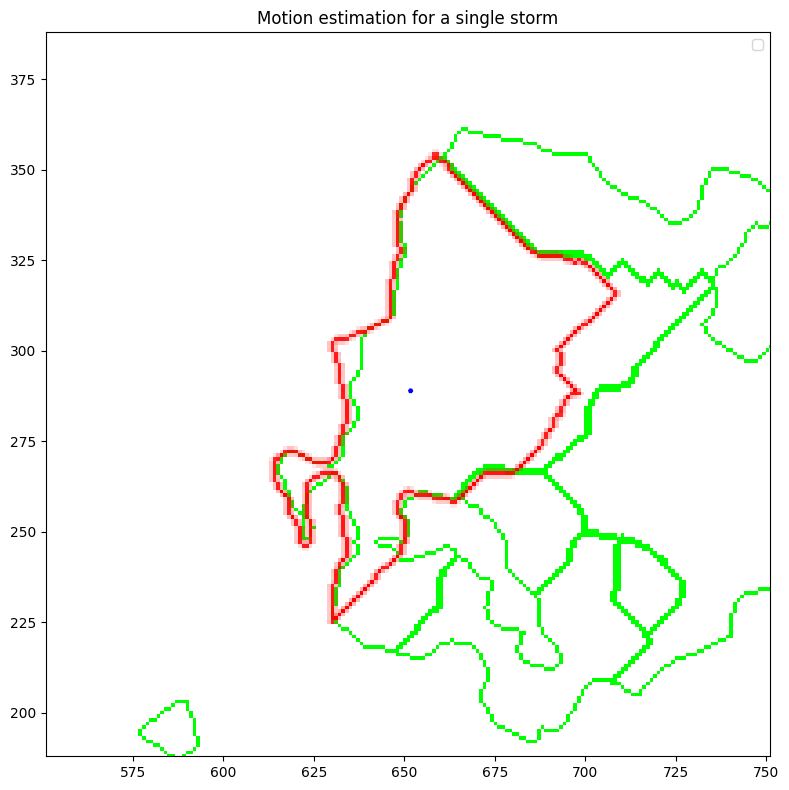

In [83]:
storms_map_1 = storms_map_time_lst[0]
storms_map_2 = storms_map_time_lst[1]
block_size = 64
grid_y, grid_x, vy, vx = storms_map_2.trec_estimate(storms_map_1, block_size=block_size, stride=block_size)

plt.figure(figsize=(8,12))

# plt.subplot(2,1,1)
# # Plot motion vectors
# plt.quiver(
#     grid_x, grid_y,        # vector positions (centers of blocks)
#     vx, vy,                # vector components (dx, dy)
#     # angles="xy", 
#     scale_units="xy", 
#     scale=1,
#     color="red", 
#     # width=0.003
# )

# plt.title(f"Motion field overlaid on reflectivity with block_size {block_size}")
# plt.xlabel("x (pixels)")
# plt.ylabel("y (pixels)")

# plt.subplot(2,1,2)
storm_order = 1
storm = storms_map_2.storms[storm_order]
contours = convert_polygons_to_contours([storm.contour])

curr_contours = convert_polygons_to_contours([storm.contour for storm in storms_map_1.storms])
blank_image = np.ones(img_shape, np.uint8) * 255
cv2.drawContours(blank_image, curr_contours, -1, (0,255,0))
cv2.drawContours(blank_image, contours, -1, (255,0,0), lineType=cv2.LINE_AA)

x_centroid, y_centroid = storm.centroid

dy, dx = storm.retrieve_movement()

print(dy, dx)

plt.quiver(
    [x_centroid-dx], [y_centroid-dy],        # vector positions (centers of blocks)
    [dx], [dy],                # vector components (dx, dy)
    angles="xy", 
    scale_units="xy", 
    scale=1,
    color="blue",
)
# plt.plot([y_centroid, y_centroid+dy], [x_centroid, x_centroid+dx], color=(0,0,1), label=f"Movement: ({dy:.2f}, {dx:.2f})")
plt.title(f"Motion estimation for a single storm")
plt.legend()
plt.imshow(blank_image)
plt.xlim(x_centroid-100, x_centroid+100)
plt.ylim(y_centroid-100, y_centroid+100)

plt.tight_layout()
plt.show()

## 2. Tracking

### 2.1 Implementation of `Matcher`

- **Idea**: implement a 2-stage matching:

    1. Motion estimaton using TREC + overlapping technique
    
    2. Hungarian matching for those failures.

In [84]:
from src.tracking import BaseMatcher, BaseTrackingHistory, BaseTracker
from typing import Callable
from shapely.affinity import translate
from src.cores.similarity import area_overlapping_ratio

class Matcher(BaseMatcher):
    dynamic_max_velocity: Callable[[float], float]      # dynamic constraint for maximum velocity

    def __init__(self, dynamic_max_velocity: Callable[[float], float]):
        self.dynamic_max_velocity = dynamic_max_velocity
    
    def _construct_disparity_matrix(
            self, storm_lst1: list[CentroidStorm], storm_lst2: list[CentroidStorm]
        ) -> tuple[np.ndarray, np.ndarray]:
        """
        Construct the cost matrix for Hungarian matching.
        """
        # get square root of area difference
        area_lst1 = np.array([storm.contour.area for storm in storm_lst1])
        area_lst2 = np.array([storm.contour.area for storm in storm_lst2])
        area_matrix = np.sqrt(np.abs(area_lst1[:, None] - area_lst2[None, :]))

        # get centroid displacement
        centroid_lst1 = np.array([storm.centroid for storm in storm_lst1])
        centroid_lst2 = np.array([storm.centroid for storm in storm_lst2])
        centroid_displacement_matrix = np.linalg.norm(centroid_lst1[:,None,:] - centroid_lst2[None,:,:], axis=2)
        
        return area_matrix + centroid_displacement_matrix, centroid_displacement_matrix
    
    def match_storms(
            self, storms_map_1: DbzStormsMap, storms_map_2: DbzStormsMap, 
            matching_overlap_threshold: float = 0.5
        ) -> np.ndarray:
        """
        Match storms between 2 time frame.

        Args:
            storm_map_1 (StormsMap): storm map in the 1st frame.
            storm_map_2 (StormsMap): storm map in the 2nd frame.
        
        Returns:
            assignments (np.ndarray): Array of (prev_idx, curr_idx) pairs representing matched storms.
        """
        prev_num_storms = len(storms_map_1.storms)
        curr_num_storms = len(storms_map_2.storms)
        
        # Step 1: match using forecasting + overlap ratio
        curr_polygons = [storm.contour for storm in storms_map_2.storms]

        assignments = []
        for i, prev_storm in enumerate(storms_map_1.storms):
            # use TREC-based estimated movement
            dy, dx = prev_storm.retrieve_movement()
            if dy is None or dx is None:    # case no estimated movement
                continue
            pred_pol = translate(prev_storm.contour, xoff=dx, yoff=dy)
            
            # get storms with overlapping ratio > threshold
            scores = [area_overlapping_ratio(pred_pol, curr_pol, mode='avg') for curr_pol in curr_polygons]
            matching_indices = np.argwhere(np.array(scores) > matching_overlap_threshold)
            assignments.extend([(i, matching_idx[0]) for matching_idx in matching_indices])

        assignments = np.array(assignments)
        if len(assignments) == 0:
            prev_matched, curr_matched = [], []
        else:
            prev_matched = list(set(assignments[:,0]))
            curr_matched = list(set(assignments[:,1]))

        ## case: all storms are matched, or 1 side is fully matched
        if len(prev_matched) == prev_num_storms or len(curr_matched) == curr_num_storms:
            return assignments
        
        # Step 2: perform 2nd matching for unmatched storms 
        cost_matrix, displacement_matrix = self._construct_disparity_matrix(storms_map_1.storms, storms_map_2.storms)

        ## adjust the cost matrix
        dt = (storms_map_2.time_frame - storms_map_1.time_frame).seconds / 3600     # unit: hr
        invalid_mask = np.ones_like(cost_matrix, dtype=bool)    # initialize all as invalid

        for i in range(prev_num_storms):
            # case: storm i in prev is already matched => continue
            if i in prev_matched:
                continue
            for j in range(curr_num_storms):
                # case: storm j in curr is already matched => continue
                if j in curr_matched:
                    continue

                # check for dynamic velocity constraint
                max_area = max(storms_map_1.storms[i].contour.area, storms_map_2.storms[j].contour.area)
                max_displacement = self.dynamic_max_velocity(max_area) * dt
                if displacement_matrix[i][j] <= max_displacement:
                    invalid_mask[i][j] = 0

        cost_matrix = cost_matrix + invalid_mask * 1e6
        row_ind, col_ind = self._hungarian_matching(cost_matrix)

        assignment_mask = np.zeros_like(cost_matrix, dtype=bool)
        assignment_mask[row_ind, col_ind] = True

        assignments_2 = np.argwhere(assignment_mask & np.logical_not(invalid_mask))

        if len(assignments) == 0:
            return assignments_2
        if len(assignments_2) == 0:
            return assignments
        
        return np.concatenate([assignments, assignments_2], axis=0)

In [85]:
def dynamic_max_velocity(area: float) -> float:
    """
    Dynamic constraint for maximum velocity based on storm area. The unit of velocity is pixel/hr.
    """
    if area < 300:
        return 50
    elif area < 500:
        return 75
    else:
        return 100

matcher = Matcher(dynamic_max_velocity=dynamic_max_velocity)
assignments = matcher.match_storms(storms_map_time_lst[0], storms_map_time_lst[1])
assignments

array([[ 0,  0],
       [ 5,  7],
       [ 9, 12],
       [10, 13]])

### 2.2 Implementation of `TrackingHistory`

- **Idea**: keep track of storms evolution over time.

- **Public methods**:
    - $\textcolor{yellow}{\text{forecast}}$: forecast the next position of current storm track.
    - $\textcolor{yellow}{\text{update}}$: receive the mapping of current storms and update the track.

In [86]:
from dataclasses import dataclass, field
from copy import deepcopy

@dataclass
class StormRecord:
    """
    Record: is a part of `StormTrack`, contains information about a storm at a specific time frame.
    """
    track_id: int
    storm: CentroidStorm
    time_frame: datetime
    is_virtual: bool = field(default=False)      # if virtual: the current storm of the corresponding track is splitted and this storm is created to keep track of the splitted part.
    parent_track_id: int = field(default=None)   # if virtual: the id of the parent track from which this storm is splitted.

@dataclass
class StormTrack:
    """
    Track: contains the history of a storm over time frames.
    """
    id: int
    records: list[StormRecord] = field(default_factory=list)
    movements: list[np.ndarray] = field(default_factory=list)   # list of movement vectors over time
    active: bool = field(default=True)                          # whether the track is still active or not
    merged: bool = field(default=False)                         # in case the track is inactive, check whether the track has been merged into another track
    merged_to: int = field(default=None)                        # if merged, the id of the track to which this track is merged

    def add_record(self, record: StormRecord, motion_vector: np.ndarray = None):
        self.records.append(record)
        if motion_vector is not None:
            self.movements.append(motion_vector)
    
    def get_latest_record(self) -> StormRecord:
        return self.records[-1] if self.records else None
    
    def get_copy(self, new_id: int, last_time: datetime) -> "StormTrack":
        """
        Return a copy of the current track with a new id.
        """
        new_track = StormTrack(id=new_id)
        new_track.records = deepcopy(self.records)
        for record in new_track.records:
            record.track_id = new_id
            record.is_virtual = True
            record.parent_track_id = self.id

        for movement in self.movements:
            new_track.movements.append(deepcopy(movement))

        if len(new_track.records) > 0 and new_track.records[-1].time_frame >= last_time:
            # drop the last record if it exceeds the last time
            new_track.records.pop()
            if len(new_track.movements) > 0:
                new_track.movements.pop()

        return new_track


In [87]:
from copy import deepcopy
from shapely.affinity import translate

class TrackingHistory(BaseTrackingHistory):
    def __init__(self, storms_map: StormsMap):
        self.tracks = []
        for storm in storms_map.storms:
            self.tracks.append(self._initialize_track(storm, storms_map.time_frame))

        self.storm_dict = {storm.id: idx for idx, storm in enumerate(storms_map.storms)}
        self.active_list = list(range(len(self.storm_dict)))
    
    def _initialize_track(self, storm: CentroidStorm, time_frame: datetime):
        new_id = len(self.tracks)
        return StormTrack(
            id=new_id,
            records=[StormRecord(
                track_id=new_id,
                storm=storm,
                time_frame=time_frame
            )]
        )
    
    def _get_track(self, storm_id: str) -> StormTrack:
        """
        Get the track of storm with storm_id, if there is no track found, raise `KeyError`.

        Args:
            storm_id (str): id of the storm
        
        Returns:
            track (StormTrack)
        """
        if storm_id not in self.storm_dict:
            raise KeyError(f"Storm not found in the current track.")
        track_id = self.storm_dict[storm_id]
        return self.tracks[track_id]
    
    def _interpolate_velocity(self, velocity_lst: list[np.ndarray], alpha_decay: float = 0.5):
        """
        Interpolate the velocity using exponential decay weights.
        """
        if len(velocity_lst) == 1:
            return velocity_lst[0]
        
        weights = np.array([alpha_decay**i for i in range(len(velocity_lst))])
        total_w = np.sum(weights)
        return np.sum([displ * w / total_w for displ, w in zip(velocity_lst[::-1], weights)], axis=0)

    def forecast(self, storm_id: str, dt: float, default_motion: np.ndarray = np.array([0,0])) -> CentroidStorm:
        """
        Make a forecast for the next position of the track with track_id using the history.
        
        Args:
            storm_id (int): id of the storm.
            dt (float): the interval between the current and next frame.
            default_motion (np.ndarray, default): default motion used in case there is no recorded history.
        
        Returns:
            storm (CentroidStorm): the estimated storm in the next frame.
        """
        track = self._get_track(storm_id)
        if not track.active:
            print(f"⚠️ Storm has been expired")
            
        curr_storm = track.get_latest_record().storm

        velocity_lst = track.movements
        if len(velocity_lst) == 0:      # if no recorded velocity => use the default motion.
            velocity_lst = [default_motion]
        
        dy, dx = self._interpolate_velocity(velocity_lst) * dt
        new_pol = translate(curr_storm.contour, xoff=dx, yoff=dy)
        new_centroid = curr_storm.centroid + np.array(dx, dy)

        return CentroidStorm(new_pol, centroid=new_centroid)

    def _handle_merge(self, merge_lst: list[dict]) -> np.ndarray:
        """
        Combine the list of storms to generate the parent storm history.
        
        Args:
            merge_lst (list[dict]): contains information about the storm, including movement history, area.
        """
        weights = np.array([s["area"] for s in merge_lst])
        movements_lst = [np.array(s["movement"])[::-1] for s in merge_lst]  # revert for matching the time.

        combined_len = max([len(movements) for movements in movements_lst]) # length of parent = max length of its child
        parent_movement = np.zeros(shape=(combined_len, 2), dtype=np.float64)

        # for each time, if the
        for i in range(combined_len):
            total_value, total_weight = np.zeros(shape=(2,)), 0
            for weight, movements in zip(weights, movements_lst):
                if len(movements) <= i:
                    continue
                total_value += movements[i]
                total_weight += weight
            parent_movement[i] = total_value / total_weight
        
        return parent_movement[::-1]
    
    def _handle_split(self):
        pass

    def update(
            self, prev_mapping: dict, curr_mapping: dict, prev_storms_map: DbzStormsMap, curr_storms_map: DbzStormsMap,
        ):
        """
        Update the tracking history using the new mapping data.

        Args:
            prev_mapping (dict): key -> idx of prev storm; items -> list[idx of curr storm].
            curr_mapping (dict): key -> idx of curr storm; items -> list[idx of prev storm].
            time_frame (datetime): time of current mapping.
        """
        active_lst = []         # update the new active list
        curr_time = curr_storms_map.time_frame
        prev_time = prev_storms_map.time_frame

        dt = (curr_time - prev_time).seconds / 3600

        def get_movement(curr_order):
            """
            Get the TREC-based movement from prev storm to curr storm.
            """
            displacement = curr_storms_map.storms[curr_order].retrieve_movement()
            if displacement[0] is None or displacement[1] is None:
                raise ValueError(f"Storm {curr_storms_map.storms[curr_order].id} is None")
            
            return np.array(displacement) / dt

        for curr_idx, matched in curr_mapping.items():
            curr_storm = curr_storms_map.storms[curr_idx]
            movement = get_movement(curr_idx)

            ## Case 1: no previous matching => create the new track.
            if len(matched) == 0:
                # create new track
                self.tracks.append(self._initialize_track(curr_storm, curr_time))

                # update storm dict and active_lst
                new_tid = len(self.tracks) - 1
                self.storm_dict[curr_storm.id] = new_tid
                active_lst.append(new_tid)
            
            # Case 2: more than 1 parent storms => merged
            elif len(matched) > 1:
                merge_lst = []
                max_score = 0
                longest_history = 0
                track_id = None

                for prev_idx in matched:
                    prev_storm = prev_storms_map.storms[prev_idx]   # get the previous storm

                    track = self._get_track(prev_storm.id)          # get the corresponding track
                    area = prev_storm.contour.area
                    if area > max_score and longest_history <= len(track.records):
                        max_score = area
                        longest_history = len(track.records)
                        track_id = self.storm_dict[prev_storm.id]   # track with highest area will be extended, others are terminated
                    
                    merge_lst.append({
                        "area": prev_storm.contour.area,
                        "movement": track.movements + [movement],    # append the current movement
                    })
                
                current_track: StormTrack = self.tracks[track_id]
                
                movement_history = self._handle_merge(merge_lst)    # resolve the history
                current_track.add_record(StormRecord(
                    track_id=track_id,
                    storm=curr_storm,
                    time_frame=curr_time
                ), None)
                current_track.movements = list(movement_history)    # update the movement history

                # update storm dict & active lst
                active_lst.append(track_id)
                self.storm_dict[curr_storm.id] = track_id
            
            # Case 3: only 1 parent storm
            else:
                prev_idx = matched[0]
                prev_storm = prev_storms_map.storms[prev_idx]   # get the previous storm

                # case 3.1: parent has more than 2 childrens => split
                #   => movement = combined centroid - previous storm centroid
                if len(prev_mapping[prev_idx]) > 1:
                    # copy the previous track into the new, then update parameters.
                    new_track = self._get_track(prev_storm.id).get_copy(new_id=len(self.tracks), last_time=curr_time)

                    self.tracks.append(new_track)
                    new_track.add_record(
                        StormRecord(
                            track_id=new_track.id,
                            storm=curr_storm,
                            time_frame=curr_time), 
                        motion_vector=movement
                    )

                    new_tid = len(self.tracks) - 1
                    self.storm_dict[curr_storm.id] = new_tid
                    active_lst.append(new_tid)

                # case 3.2: one-to-one parent-child
                else:
                    # update the current track
                    current_track = self._get_track(prev_storm.id)
                    current_track.add_record(
                        record=StormRecord(
                            track_id=current_track.id,
                            storm=curr_storm,
                            time_frame=curr_time
                    ), motion_vector=movement)

                    track_id = self.storm_dict[prev_storm.id]
                    self.storm_dict[curr_storm.id] = track_id
                    active_lst.append(track_id)

        for track_id in self.active_list:
            if track_id not in active_lst:
                self.tracks[track_id].active = False
                
        self.active_list = sorted(active_lst)

    def print_tracks(self):
        for id, track in enumerate(self.tracks):
            print(f"Track {id:2d}. " + " -> ".join(record.storm.id for record in track.records))
            print(f"Status: {'ACTIVE' if track.active else 'EXPIRED'}")
            print(f"Lifespan: {len(track.records)}")
            print(f"Last track: {track.records[-1].time_frame.strftime('%Y-%m-%d %H:%M:%S')}")
            print(f"-" * 50)

### 2.3 Implementation of `Tracker`

- **Idea**: a common class that keep everything about the tracking step.

- **Methods**:
    - $\textcolor{yellow}{\text{fit}}$: receive the list of storms over time, match them step-by-step and record the tracking history.
    - $\textcolor{yellow}{\text{predict}}$: predict the next position of the current track.

In [88]:
from shapely import Point
from src.cores.metrics import pod_score, far_score, csi_score
from src.tracking import BaseTracker

class Tracker(BaseTracker):
    matcher: Matcher
    tracker: TrackingHistory

    def __init__(self, dynamic_max_velocity: Callable[[float], float]):
        self.matcher = Matcher(dynamic_max_velocity)
        
    def fit(self, storms_map_time_lst: list[DbzStormsMap], test=False):
        self.tracker = TrackingHistory(storms_map_time_lst[0])
        csi_scores, far_scores, pod_scores, frames = [], [], [], []

        for idx in range(0, len(storms_map_time_lst)-1):
            # get the current maps
            prev_storms_map, curr_storms_map = storms_map_time_lst[idx], storms_map_time_lst[idx+1]
            dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600   # scaled to hour

            # match using Hungarian algorithm
            assignments = self.matcher.match_storms(prev_storms_map, curr_storms_map)

            # resolve merge & split
            ## mapping: dict where key -> index of storm; value -> list of tuple[storm_id]
            mapping_prev = {}
            mapping_curr = {}
            for prev_idx, curr_idx in assignments:
                if int(prev_idx) not in mapping_prev:
                    mapping_prev[int(prev_idx)] = []
                mapping_prev[int(prev_idx)].append(int(curr_idx))

                if int(curr_idx) not in mapping_curr:
                    mapping_curr[int(curr_idx)] = []
                mapping_curr[int(curr_idx)].append(int(prev_idx))

            prev_assigned, curr_assigned = mapping_prev.keys(), mapping_curr.keys()
            prev_unassigned = [idx for idx in range(len(prev_storms_map.storms)) if idx not in prev_assigned]
            curr_unassigned = [idx for idx in range(len(curr_storms_map.storms)) if idx not in curr_assigned]


            if len(prev_unassigned) > 0 or len(curr_unassigned) > 0:  # if any unassigned => resolve
                pred_storms_map = StormsMap([
                        self.tracker.forecast(storm.id, dt)
                        for storm in prev_storms_map.storms
                    ], time_frame=curr_storms_map.time_frame)

                # Check for merging
                for prev_idx in prev_unassigned:
                    pred_storm = pred_storms_map.storms[prev_idx]

                    # Find storms that the predicted centroid fall into.
                    candidates = [
                            idx for idx, storm in enumerate(curr_storms_map.storms) \
                                if storm.contour.contains(Point(pred_storm.centroid))
                        ]
                    
                    if len(candidates) == 0:
                        mapping_prev[prev_idx] = []
                        continue
                    
                    child_storm_idx = candidates[0]

                    # Case: more than 1 candidates => choose one with maximum overlapping on prev_storm
                    if len(candidates) > 1:
                        def compute_overlapping(curr_idx):
                            return pred_storm.contour.intersection(curr_storms_map.storms[curr_idx].contour).area / pred_storm.contour.area
                        
                        child_storm_idx = max(candidates, key=compute_overlapping)
                    
                    # update mapping_prev & mapping_curr
                    mapping_prev[prev_idx] = [child_storm_idx]

                    if child_storm_idx not in mapping_curr:
                        mapping_curr[child_storm_idx] = []

                    mapping_curr[child_storm_idx].append(prev_idx)
                
                # Check for splitting
                for curr_idx in curr_unassigned:
                    curr_storm = curr_storms_map.storms[curr_idx]
                    # Find predicted storms that the current centroid fall into.
                    candidates = [
                            idx for idx, storm in enumerate(pred_storms_map.storms) \
                                if storm.contour.contains(Point(curr_storm.centroid))
                        ]
                    
                    if len(candidates) == 0:
                        mapping_curr[curr_idx] = []
                        continue

                    parent_storm_idx = candidates[0]

                    # Case: more than 1 candidates => only choose one with maximum overlapping on prev_storm
                    if len(candidates) > 1:
                        def compute_overlapping(i):
                            return curr_storm.contour.intersection(pred_storms_map.storms[i].contour).area / curr_storm.contour.area
                        
                        parent_storm_idx = max(candidates, key=compute_overlapping)

                    # update mapping_prev & mapping_curr
                    mapping_curr[curr_idx] = [parent_storm_idx]

                    if parent_storm_idx not in mapping_prev:
                        mapping_prev[parent_storm_idx] = []

                    mapping_prev[parent_storm_idx].append(curr_idx)
            
            if test:
                pred_storms_map = StormsMap([
                        self.tracker.forecast(storm.id, dt)
                        for storm in prev_storms_map.storms
                    ], time_frame=curr_storms_map.time_frame)
                csi_scores.append(csi_score(pred_storms_map, curr_storms_map))
                far_scores.append(far_score(pred_storms_map, curr_storms_map))
                pod_scores.append(pod_score(pred_storms_map, curr_storms_map))
                frames.append(curr_storms_map.time_frame)

            # update TREC-based movement estimation for current storms map
            curr_storms_map.trec_estimate(prev_storms_map, block_size=64, stride=64)
            
            self.tracker.update(mapping_prev, mapping_curr, prev_storms_map, curr_storms_map)
        
        if test:
            return csi_scores, far_scores, pod_scores, frames
    
    def predict(self, storm: CentroidStorm, dt: float):
        try:
            return self.tracker.forecast(storm.id, dt)
        except KeyError:
            print(f"❗ Storm not found on the track. `None` will be returned.")
            return None

In [89]:
def dynamic_max_velocity(area: float) -> float:
    """
    Dynamic constraint for maximum velocity based on storm area. The unit of velocity is pixel/hr.
    """
    if area < 300:
        return 50
    elif area < 500:
        return 75
    else:
        return 100

tracker = Tracker(dynamic_max_velocity=dynamic_max_velocity)
csi_scores, far_scores, pod_scores, frames = tracker.fit(storms_map_time_lst, test=True)

tracker.tracker.print_tracks()

Track  0. time_0_storm_0
Status: EXPIRED
Lifespan: 1
Last track: 2025-01-08 03:10:44
--------------------------------------------------
Track  1. time_0_storm_1
Status: EXPIRED
Lifespan: 1
Last track: 2025-01-08 03:10:44
--------------------------------------------------
Track  2. time_0_storm_2
Status: EXPIRED
Lifespan: 1
Last track: 2025-01-08 03:10:44
--------------------------------------------------
Track  3. time_0_storm_3
Status: EXPIRED
Lifespan: 1
Last track: 2025-01-08 03:10:44
--------------------------------------------------
Track  4. time_0_storm_4
Status: EXPIRED
Lifespan: 1
Last track: 2025-01-08 03:10:44
--------------------------------------------------
Track  5. time_0_storm_5 -> time_1_storm_7 -> time_2_storm_2 -> time_3_storm_2 -> time_4_storm_3 -> time_5_storm_3 -> time_6_storm_4 -> time_7_storm_8 -> time_8_storm_7 -> time_9_storm_7
Status: EXPIRED
Lifespan: 10
Last track: 2025-01-08 04:04:46
--------------------------------------------------
Track  6. time_0_stor

## 3. Nowcasting

In [91]:
from src.cores.metrics import pod_score, far_score, csi_score

bm_pod_scores = []
bm_far_scores = []
bm_csi_scores = []

print("Naive nowcasting prediction: Only using the last map without any motion update")
print("Results:")
for idx in range(len(storms_map_time_lst)-1):
    prev_storm = storms_map_time_lst[idx]
    curr_storm = storms_map_time_lst[idx+1]
    bm_pod_scores.append(pod_score(prev_storm, curr_storm))
    bm_far_scores.append(far_score(prev_storm, curr_storm))
    bm_csi_scores.append(csi_score(prev_storm, curr_storm))
    print(f"\tTime {curr_storm.time_frame.strftime('%Y-%m-%d %H:%M:%S')} | POD: {pod_score(prev_storm, curr_storm):.4f} | FAR: {far_score(prev_storm, curr_storm):.4f} | CSI: {csi_score(prev_storm, curr_storm):.4f}")

indexes = range(len(bm_pod_scores))
scores = [bm_pod_scores, bm_far_scores, bm_csi_scores]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']

Naive nowcasting prediction: Only using the last map without any motion update
Results:
	Time 2025-01-08 03:16:44 | POD: 0.9154 | FAR: 0.0951 | CSI: 0.8351
	Time 2025-01-08 03:22:45 | POD: 0.7932 | FAR: 0.5218 | CSI: 0.4252
	Time 2025-01-08 03:28:45 | POD: 0.8986 | FAR: 0.1545 | CSI: 0.7719
	Time 2025-01-08 03:34:45 | POD: 0.8945 | FAR: 0.1646 | CSI: 0.7605
	Time 2025-01-08 03:40:45 | POD: 0.6867 | FAR: 0.4947 | CSI: 0.4106
	Time 2025-01-08 03:46:46 | POD: 0.8715 | FAR: 0.1426 | CSI: 0.7611
	Time 2025-01-08 03:52:46 | POD: 0.4461 | FAR: 0.5755 | CSI: 0.2780
	Time 2025-01-08 03:58:46 | POD: 0.8244 | FAR: 0.2353 | CSI: 0.6576
	Time 2025-01-08 04:04:46 | POD: 0.8010 | FAR: 0.1854 | CSI: 0.6775
	Time 2025-01-08 04:10:47 | POD: 0.7098 | FAR: 0.3527 | CSI: 0.5118
	Time 2025-01-08 04:16:47 | POD: 0.8456 | FAR: 0.1519 | CSI: 0.7344
	Time 2025-01-08 04:22:47 | POD: 0.4203 | FAR: 0.6451 | CSI: 0.2383
	Time 2025-01-08 04:28:47 | POD: 0.7256 | FAR: 0.3909 | CSI: 0.4951
	Time 2025-01-08 04:34:48 | 

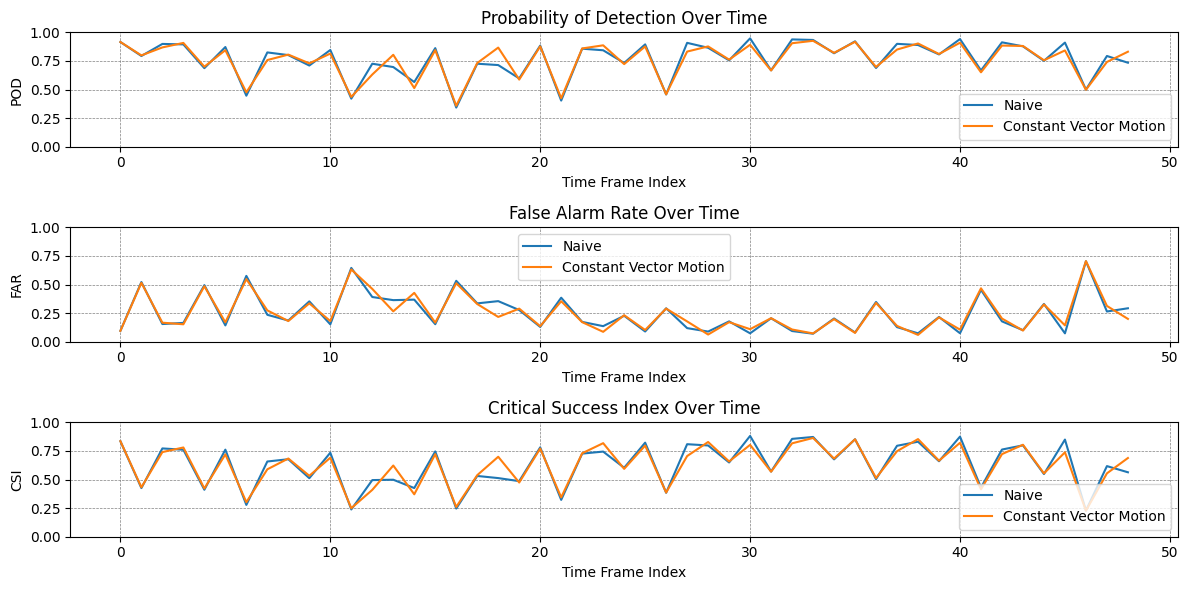

In [92]:
indexes = range(len(bm_pod_scores))
scores = [
    (bm_pod_scores, pod_scores), 
    (bm_far_scores, far_scores),
    (bm_csi_scores, csi_scores)
]
titles = ['Probability of Detection Over Time', 'False Alarm Rate Over Time', 'Critical Success Index Over Time']
ylabels = ['POD', 'FAR', 'CSI']

plt.figure(figsize=(12, 6))

for i, title in enumerate(titles):
    plt.subplot(3, 1, i+1)
    plt.plot(indexes, scores[i][0], label='Naive')
    plt.plot(indexes, scores[i][1], label='Constant Vector Motion')
    plt.title(title)
    plt.xlabel('Time Frame Index')
    plt.ylabel(ylabels[i])
    plt.ylim(0, 1)
    plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
    plt.legend()

plt.tight_layout()
plt.show()

In [93]:
# import pandas as pd
# import os

# time_frame_list = [storms_map.time_frame for storms_map in storms_map_time_lst[:-1]]

# output_dir = f'output/{data_name}'
# os.makedirs(output_dir, exist_ok=True)

# df = pd.DataFrame({
#     'time': time_frame_list,
#     'POD': pod_scores,
#     'POD_Naive': bm_pod_scores,
#     'FAR': far_scores,
#     'FAR_Naive': bm_far_scores,
#     'CSI': csi_scores,
#     'CSI_Naive': bm_csi_scores,
# })

# df.to_csv(f'{output_dir}/ETITAN.csv', index=False)

## 4. Evaluation

In [94]:
train_idx = 20
test_idx = 25

prev_storms_map = storms_map_time_lst[train_idx-1]
curr_storms_map = storms_map_time_lst[test_idx]
next_storms_map = storms_map_time_lst[test_idx+1]

dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600.0
print(f"Overhead time: {dt * 60:.2f} minutes")

tracker = Tracker(dynamic_max_velocity=dynamic_max_velocity)
tracker.fit(storms_map_time_lst[:train_idx], test=False)

pred_storms_map = DbzStormsMap([
        tracker.tracker.forecast(storm.id, dt)
        for storm in prev_storms_map.storms
    ], time_frame=curr_storms_map.time_frame, dbz_map=curr_storms_map.dbz_map)

print(f"POD score: {pod_score(pred_storms_map, curr_storms_map):.4f}")
print(f"FAR score: {far_score(pred_storms_map, curr_storms_map):.4f}")
print(f"CSI score: {csi_score(pred_storms_map, curr_storms_map):.4f}")

Overhead time: 36.02 minutes
POD score: 0.2688
FAR score: 0.4897
CSI score: 0.2137


In [95]:
import pandas as pd

def forecast_evaluation(lead_time: int, train_len: int):
    pod_scores = []
    csi_scores = []
    far_scores = []
    leading_times = []

    time_list = range(train_len, len(storms_map_time_lst)-lead_time)

    for train_idx in tqdm(time_list, total=len(time_list)):
        test_idx = train_idx + lead_time

        prev_storms_map = storms_map_time_lst[train_idx-1]
        curr_storms_map = storms_map_time_lst[test_idx]

        dt = (curr_storms_map.time_frame - prev_storms_map.time_frame).seconds / 3600.0

        tracker = Tracker(dynamic_max_velocity=dynamic_max_velocity)
        tracker.fit(storms_map_time_lst[train_idx-train_len:train_idx], test=False)

        pred_storms_map = StormsMap([
                tracker.tracker.forecast(storm.id, dt)
                for storm in prev_storms_map.storms
            ], time_frame=curr_storms_map.time_frame)
        
        pod = pod_score(pred_storms_map, curr_storms_map)
        csi = csi_score(pred_storms_map, curr_storms_map)
        far = far_score(pred_storms_map, curr_storms_map)

        pod_scores.append(pod)
        csi_scores.append(csi)
        far_scores.append(far)
        leading_times.append(dt * 60)  # convert to minutes

    forecast_leads_df = pd.DataFrame({
        'time': [storms_map_time_lst[i+lead_time].time_frame for i in time_list],
        'POD': pod_scores,
        'FAR': far_scores,
        'CSI': csi_scores,
        'leading_time (min)': leading_times
    })

    output_dir = f'output/{data_name}/{lead_time}_frame_leads'
    os.makedirs(output_dir, exist_ok=True)

    forecast_leads_df.to_csv(f'{output_dir}/ETITAN.csv', index=False)

    print(f"Store file successfully to {output_dir}/ETITAN.csv")

    return forecast_leads_df

### 4.1 3-frame leads

In [96]:
df = forecast_evaluation(lead_time=3, train_len=10)
df

  0%|          | 0/37 [00:00<?, ?it/s]

Store file successfully to output/philippines_13.269_123.832/3_frame_leads/ETITAN.csv


,time,POD,FAR,CSI,leading_time (min)
0,2025-01-08 04:28:47,0.411700,0.729193,0.195251,24.016667
1,2025-01-08 04:34:48,0.341008,0.774035,0.157284,24.016667
2,2025-01-08 04:40:48,0.229150,0.830624,0.107899,24.016667
3,2025-01-08 04:46:48,0.279800,0.758289,0.149006,24.016667
4,2025-01-08 04:52:48,0.291672,0.600044,0.202890,24.016667
5,2025-01-08 04:58:49,0.297459,0.591140,0.208002,24.016667
6,2025-01-08 05:04:49,0.176227,0.800135,0.103329,24.016667
7,2025-01-08 05:10:49,0.295027,0.595969,0.205568,24.016667
8,2025-01-08 05:16:49,0.405158,0.578314,0.260443,24.016667
9,2025-01-08 05:22:50,0.348567,0.427044,0.276684,24.016667


### 4.2 5-frame leads

In [97]:
df = forecast_evaluation(lead_time=5, train_len=10)
df

  0%|          | 0/35 [00:00<?, ?it/s]

Store file successfully to output/philippines_13.269_123.832/5_frame_leads/ETITAN.csv


,time,POD,FAR,CSI,leading_time (min)
0,2025-01-08 04:40:48,0.202666,0.860435,0.090095,36.033333
1,2025-01-08 04:46:48,0.172376,0.873739,0.078608,36.016667
2,2025-01-08 04:52:48,0.127938,0.871813,0.068412,36.016667
3,2025-01-08 04:58:49,0.126957,0.864485,0.070146,36.033333
4,2025-01-08 05:04:49,0.315092,0.642068,0.201308,36.033333
5,2025-01-08 05:10:49,0.229707,0.654463,0.160066,36.016667
6,2025-01-08 05:16:49,0.227034,0.690006,0.150818,36.016667
7,2025-01-08 05:22:50,0.204249,0.579879,0.159330,36.033333
8,2025-01-08 05:28:50,0.286860,0.550384,0.212308,36.033333
9,2025-01-08 05:34:50,0.298444,0.513780,0.226891,36.016667
